In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *




In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

In [6]:
#lines = spark.read.csv("gs://dataset-rs/dataset-last.fm/dataset_lastfm.csv", header="true",inferSchema="true").rdd
lines = spark.read.csv("/home/aleja/Documentos/datasets/meu-lastfm/lastFM_v2.csv", header="true",inferSchema="true").rdd

lines.take(2)

[Row(_c0=0, _id='5afe3eaf5030e62c08fc9860', name='fernandomaiscal', topTracks_artist_mbid='c3d14b41-a48d-488f-bfed-ce0597bb0b1f', topTracks_artist_name='Kenny Rogers', topTracks_mbid='3a3a8a18-32a4-41f5-a443-61cc28a23c0a', topTracks_name='All I Ever Need Is You (feat. Dottie West)', topTracks_playcount='110', new_userId='0', new_songId=51749, new_artistId=19278),
 Row(_c0=1, _id='5afe3eaf5030e62c08fc9860', name='fernandomaiscal', topTracks_artist_mbid='145a7738-d7fb-4041-9da6-1c26790f899d', topTracks_artist_name='Geraldo Azevedo', topTracks_mbid='9c41b5e4-0bba-40b7-bcf4-f2b70c4f61c7', topTracks_name='Dia Branco', topTracks_playcount='53', new_userId='0', new_songId=138893, new_artistId=1799)]

In [7]:
#Create dataframe
ratings = spark.createDataFrame(lines) 
ratings = ratings.withColumn("topTracks_playcount", col("topTracks_playcount").cast('int'))

ratings

DataFrame[_c0: bigint, _id: string, name: string, topTracks_artist_mbid: string, topTracks_artist_name: string, topTracks_mbid: string, topTracks_name: string, topTracks_playcount: int, new_userId: string, new_songId: bigint, new_artistId: bigint]

In [8]:
#50% Sample of data 
df_ratings = ratings.sample(False,fraction=0.5, seed=1)
df_ratings.select('_Id').count()

650664

In [9]:
#Drop NaN data 
df_ratings = df_ratings.na.drop()


6401

In [10]:
df_ratings.show(5)

+---+--------------------+---------------+---------------------+---------------------+--------------------+--------------------+-------------------+----------+----------+------------+
|_c0|                 _id|           name|topTracks_artist_mbid|topTracks_artist_name|      topTracks_mbid|      topTracks_name|topTracks_playcount|new_userId|new_songId|new_artistId|
+---+--------------------+---------------+---------------------+---------------------+--------------------+--------------------+-------------------+----------+----------+------------+
|  0|5afe3eaf5030e62c0...|fernandomaiscal| c3d14b41-a48d-488...|         Kenny Rogers|3a3a8a18-32a4-41f...|All I Ever Need I...|                110|         0|     51749|       19278|
|  2|5afe3eaf5030e62c0...|fernandomaiscal| 4d5447d7-c61c-412...|          John Lennon|0b9928a1-d751-49d...|    Gimme Some Truth|                 49|         0|     10120|        7137|
|  3|5afe3eaf5030e62c0...|fernandomaiscal| 5441c29d-3602-489...|          David 

In [11]:
df_ratings.printSchema()

root
 |-- _c0: long (nullable = true)
 |-- _id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- topTracks_artist_mbid: string (nullable = true)
 |-- topTracks_artist_name: string (nullable = true)
 |-- topTracks_mbid: string (nullable = true)
 |-- topTracks_name: string (nullable = true)
 |-- topTracks_playcount: integer (nullable = true)
 |-- new_userId: string (nullable = true)
 |-- new_songId: long (nullable = true)
 |-- new_artistId: long (nullable = true)



In [12]:
df_ratings = df_ratings.withColumn("new_userId", col("new_userId").cast("int"))
df_ratings = df_ratings.withColumn("new_songId", col("new_songId").cast("int"))
df_ratings = df_ratings.withColumn("new_artistId", col("new_artistId").cast("int"))




## change ids from strings to integers


In [ ]:
#userId_change = df_ratings.select('_Id').distinct().select('_Id', monotonically_increasing_id().alias('new_userId'))
#songId_change = df_ratings.select('topTracks_mbid').distinct().select('topTracks_mbid', monotonically_increasing_id().alias('new_songId'))
#artistId_change = df_ratings.select('topTracks_artist_mbid').distinct().select('topTracks_artist_mbid', monotonically_increasing_id().alias('new_artistId'))


In [ ]:
#userId_change.orderBy('new_userID').show(100, truncate=False)

In [ ]:
#songId_change.orderBy('new_songId').show(1000, truncate=False)

In [ ]:
# join dataframes
#df_ratings_with_int_ids = df_ratings.join(userId_change, '_Id').join(songId_change, 'topTracks_mbid').join(artistId_change, 'topTracks_artist_mbid')
#df_ratings_with_int_ids

In [ ]:
#df_ratings_with_int_ids = df_ratings_with_int_ids.withColumn("new_userId", col("new_userId").cast("decimal.Decimal"))
#df_ratings_with_int_ids = df_ratings_with_int_ids.withColumn("new_songId", col("new_songId").cast("decimal.Decimal"))
#df_ratings_with_int_ids = df_ratings_with_int_ids.withColumn("new_artistId", col("new_artistId").cast("decimal.Decimal"))





In [ ]:
#df_ratings_with_int_ids.selectExpr('new_userId','new_songId','topTracks_name','topTracks_playcount').orderBy(col('new_userId'),col('new_songId')).show(100)

### TOTAL PLAY COUNT OF EACH TOP_TRACK

In [13]:
song_play1 = df_ratings.selectExpr("topTracks_name","topTracks_playcount as Total_count","topTracks_artist_name").groupBy(col('topTracks_name'),col('topTracks_artist_name')).sum("Total_count")
song_play1.orderBy("sum(Total_count)",ascending=False).show(10)

+----------------+---------------------+----------------+
|  topTracks_name|topTracks_artist_name|sum(Total_count)|
+----------------+---------------------+----------------+
|       Interlude|                 Muse|          162964|
|    Come to Dust|     Boards of Canada|          104691|
|        Skyliner|     Boards of Canada|          101510|
|       Na Batida|               Anitta|           63529|
|   Born This Way|            Lady Gaga|           59191|
| Left Side Drive|     Boards of Canada|           58479|
|Do I Wanna Know?|       Arctic Monkeys|           58262|
|Amo Bishop Roden|     Boards of Canada|           57984|
|     Born to Die|         Lana Del Rey|           57096|
|        Applause|            Lady Gaga|           48835|
+----------------+---------------------+----------------+
only showing top 10 rows



In [14]:
song_play1

DataFrame[topTracks_name: string, topTracks_artist_name: string, sum(Total_count): bigint]

In [46]:
## How many distinct users in data ?

uniqueUsers = df_ratings.select('new_userId').distinct().count()
print("Total n. of users: ", uniqueUsers)

## How many distinct artists in data ?

uniqueArtists  = df_ratings.select("new_artistId").distinct().count()
print("Total n. of artists: ", uniqueArtists)

## How many distinct music in data ?

uniqueSongs  = df_ratings.select("new_songId").distinct().count()
print("Total n. of songs: ", uniqueSongs)




Total n. of users:  6401
Total n. of artists:  20859
Total n. of songs:  152853


In [23]:
#How many times each user has played a song?
# Compute user activity
# We are interested in how many playcounts each user has scored.

userActivity =  df_ratings.groupBy("new_userId").sum("topTracks_playcount").collect()
userActivity[0:5]

[Row(new_userId=148, sum(topTracks_playcount)=14129),
 Row(new_userId=463, sum(topTracks_playcount)=5348),
 Row(new_userId=471, sum(topTracks_playcount)=2754),
 Row(new_userId=496, sum(topTracks_playcount)=670),
 Row(new_userId=833, sum(topTracks_playcount)=1169)]

[   0    1    2 ..., 6398 6399 6400]


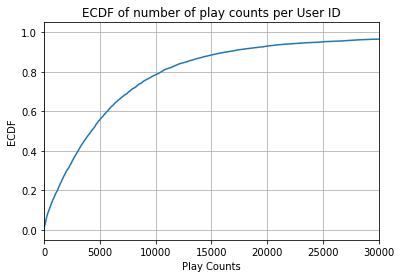

In [43]:
## Plot CDF (or ECDF) of number of play counts per User ID.
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(0,30000)   # We shrink the window 
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()


In [32]:
# Additional relevant code
percentiles = [0.03, 0.10, 0.25, 0.50, 0.75, 0.90]
for p in percentiles:
    i = np.where(yvals<=p)[0][-1]    
    print(str(p*100),"percent of the users has less than: ",Y[i]," play counts")

3.0 percent of the users has less than:  96  play counts
10.0 percent of the users has less than:  431  play counts
25.0 percent of the users has less than:  1592  play counts
50.0 percent of the users has less than:  4229  play counts
75.0 percent of the users has less than:  8852  play counts
90.0 percent of the users has less than:  16327  play counts


[    0     1     2 ..., 20856 20857 20858]


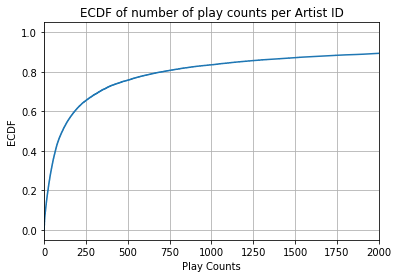

In [38]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = df_ratings.groupby("new_artistId").sum("topTracks_playcount").collect()

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(0,2000)
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

[     0      1      2 ..., 152850 152851 152852]


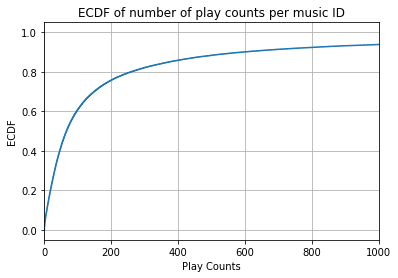

In [40]:
# Compute music popularity
# We are interested in how many playcounts per music
# ATTENTION! Grouping by artistID may be problematic, as stated above.

musicPopularity = df_ratings.groupby("new_songId").sum("topTracks_playcount").collect()

pdf = pd.DataFrame(data=musicPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(0,1000)
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per music ID')
plt.show()

In [45]:
# Additional relevant code
percentiles = [0.03, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]
for p in percentiles:
    i = np.where(yvals<=p)[0][-1]    
    print(str(p*100),"percent of the music has less than: ",Y[i]," playcount ")

3.0 percent of the music has less than:  96  playcount 
10.0 percent of the music has less than:  431  playcount 
25.0 percent of the music has less than:  1592  playcount 
50.0 percent of the music has less than:  4229  playcount 
75.0 percent of the music has less than:  8852  playcount 
90.0 percent of the music has less than:  16327  playcount 
95.0 percent of the music has less than:  24752  playcount 


### Total count of  a song listened by users

In [15]:
song_play =df_ratings.groupBy("topTracks_name", "topTracks_artist_name").count()
song_play.orderBy("count", ascending=False).show()

+--------------------+---------------------+-----+
|      topTracks_name|topTracks_artist_name|count|
+--------------------+---------------------+-----+
|    Do I Wanna Know?|       Arctic Monkeys|  689|
|           R U Mine?|       Arctic Monkeys|  606|
|         Born to Die|         Lana Del Rey|  553|
|          Blue Jeans|         Lana Del Rey|  495|
|Fluorescent Adole...|       Arctic Monkeys|  495|
|         Video Games|         Lana Del Rey|  480|
|  Summertime Sadness|         Lana Del Rey|  455|
|     Pumped Up Kicks|    Foster the People|  398|
|              Royals|                Lorde|  397|
|            Arabella|       Arctic Monkeys|  396|
|I Bet You Look Go...|       Arctic Monkeys|  395|
|                 505|       Arctic Monkeys|  384|
|          West Coast|         Lana Del Rey|  375|
|Why'd You Only Ca...|       Arctic Monkeys|  363|
|     National Anthem|         Lana Del Rey|  361|
|                Team|                Lorde|  354|
|      Mr. Brightside|         

In [16]:
df_ratings.selectExpr("new_songId", "new_artistId",'topTracks_playcount').distinct().describe().show()

+-------+------------------+------------------+-------------------+
|summary|        new_songId|      new_artistId|topTracks_playcount|
+-------+------------------+------------------+-------------------+
|  count|            569948|            569948|             569948|
|   mean|114083.84465775825|13585.331646044902|  82.92412465698625|
| stddev| 65769.97457067823| 7549.767056224133|  407.8531211469318|
|    min|                 0|                 0|                  1|
|    max|            227463|             26552|             161760|
+-------+------------------+------------------+-------------------+



In [14]:
grouped_sum0 = song_play.selectExpr('count')
grouped_sum0 = grouped_sum0.groupBy().sum().collect()[0][0]
grouped_sum0


650661

In [ ]:
y = song_play.withColumn("porcentage", (song_play['count']/grouped_sum0)*100)
#song_play.selectExpr((song_play['count'] / grouped_sum0)*100)
y.orderBy("count", ascending=False).show()


In [ ]:
music_data =  df_ratings.selectExpr("new_songId","topTracks_name","new_artistId","topTracks_artist_name")
music_data

### Split the dataset Training and test data

In [57]:
#sub_rating_data = df_ratings_with_int_ids.select("new_userId","new_songId","topTracks_playcount")
sub_rating_data = df_ratings.select("new_userId","new_songId","topTracks_playcount")
sub_rating_data
sub_rating_data.orderBy(col('new_userId'),col('new_songId')).show(10)


+----------+----------+-------------------+
|new_userId|new_songId|topTracks_playcount|
+----------+----------+-------------------+
|         0|      1140|                 16|
|         0|      1165|                 22|
|         0|      1566|                 16|
|         0|      1972|                 23|
|         0|      2798|                 30|
|         0|      5271|                 23|
|         0|      5916|                 22|
|         0|      6594|                 23|
|         0|      7632|                 13|
|         0|      7926|                 26|
+----------+----------+-------------------+
only showing top 10 rows



In [50]:
(training, test) = sub_rating_data.randomSplit([0.8, 0.2])
training.printSchema()

root
 |-- new_userId: integer (nullable = true)
 |-- new_songId: integer (nullable = true)
 |-- topTracks_playcount: integer (nullable = true)



In [47]:
#training.orderBy(col('new_userId'),col('new_songId')).show(10)

In [48]:
#test.orderBy(col('new_userId'),col('new_songId')).show(10)

### Treinando ALS

In [68]:
als = ALS(rank=10, maxIter=10, regParam=0.01, alpha=0.5, implicitPrefs=True, userCol="new_userId", itemCol="new_songId", ratingCol="topTracks_playcount", coldStartStrategy="drop")
model = als.fit(training)


In [69]:
##Predictions-  test model
predictions = model.transform(test)
#predictions.show(10)


### Acuracia do modelo

In [74]:
evaluator = RegressionEvaluator(labelCol="topTracks_playcount", predictionCol="prediction")
rmse = evaluator.evaluate(predictions.na.drop(), {evaluator.metricName :"rmse"})
mae =  evaluator.evaluate(predictions.na.drop(), {evaluator.metricName :"mae"})
print("Root-mean-square error = " + str(rmse))



Root-mean-square error = 355.5357067922846


## funcion para mejorar la Acuracia del modelo

In [ ]:
#performance 

def kfoldALS(data, k=3, userCol="new_userId", itemCol="new_songId", ratingCol="topTracks_playcount", metricName="rmse",labelCol="topTracks_playcount"):
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(sc.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol=labelCol, predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print ("Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation))
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))

In [ ]:
print ("RMSE = " + str(kfoldALS(sub_rating_data, k=2)))

## Función para recomendación

In [ ]:
from pyspark.sql.functions import lit



def recommendMusic(model, user, nbRecommendations):
     # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
    dataSet = df_ratings.select("new_songId").distinct().withColumn("new_userId", lit(user))

    # Create a Spark DataFrame with the movies that have already been rated by this user
    musicAlreadyRated = df_ratings.filter(df_ratings.new_userId == user).select("new_songId", "new_userId")

    # Apply the recommender system to the data set without the already rated movies to predict ratings
    predictions = model.transform(dataSet.subtract(musicAlreadyRated)).dropna().orderBy("prediction", ascending=False).limit(nbRecommendations).select("new_songId", "prediction")
    
    # Join with the ratings DataFrame to get the music titles and genres
    recommendations = predictions.join(music_data, predictions.new_songId == music_data.new_songId).select(predictions.new_songId, music_data.topTracks_name, music_data.topTracks_artist_name, predictions.prediction).distinct()
    recommendations.show(truncate=False)

In [ ]:
print ("Recommendations for user 8:")
recommendMusic(model,1450,5)

In [ ]:
df = spark.createDataFrame([("A", 20), ("B", 30), ("D", 80)],["Letter", "Number"])
df.show()

In [ ]:
f = df.groupBy().sum().collect()
f

In [ ]:
training.show(2)

In [ ]:
training.count()

In [ ]:
test.count()

In [ ]:
training.filter(training['topTracks_playcount'] > 4).show(10)